# AirBnB Rental Price Predictions

### Goal: Create a model that will best predict AirBnB rental prices in New York City

#### Process:
* We first found data from a site called Inside Airbnb that compiles information directly from the site. It is not affiliated with AirBnB in any way, but the information is all direct and acurate.


* In addition to general AirBnB listing data, we thought "neighborhood value" would be solid factor in predicting rental price. We utilized the Zillow API to get the median house price for each neighborhood in every AirBnB listing.


* We started the data exploration process by visualizing a few significant features individually


* We first created our "base model" that accounted for every single variable - both numerical and categorical.


* We refined that base model by using a few different feature engineering tactics, such as applying a Variance Threshold, K best, Lasso Regression and more.


* Finally, we experimented with a Random Forest model to compare to the different feature engineering methods



## Caveats:
* This is only using November data for NYC
* We took out any rental over $300 as the many outliers majorly decreased our evaluation metrics
* We eliminated neighborhoods that had less than 100 listings, and housing types that had less than 50 listings

#### There were 96 different listing columns! We chose the top 10 that we felt were the most correlated with rental price.

In [421]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

listings2 = pd.read_csv('listings.csv.gz', low_memory=False)
listings_short = listings2.filter(['price','beds', 'bathrooms','accommodates','property_type','neighbourhood','neighbourhood_group_cleansed','zipcode','review_scores_rating', 'room_type','number_of_reviews' ], axis=1)

In [422]:
listings2[listings2.price.replace('[\$,]', '', regex=True).astype(float) > 9500]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
7765,4737930,https://www.airbnb.com/rooms/4737930,20181103152857,2018-11-03,Spanish Harlem Apt,"4 minute walk the 6 train. 2 bedroom, 1 bathro...","Economical, comfortable, convenient. Be advent...","4 minute walk the 6 train. 2 bedroom, 1 bathro...",none,East Harlem is a richly cultural neighborhood ...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.02
8225,4890995,https://www.airbnb.com/rooms/4890995,20181103152857,2018-11-04,Experience NYC thru this Great Apt!,"This amazing apartment is in a safe, hip Brook...",NaN,"This amazing apartment is in a safe, hip Brook...",none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.49
10957,7003697,https://www.airbnb.com/rooms/7003697,20181103152857,2018-11-03,Furnished room in Astoria apartment,1 room with a twin bed in a 2 bedroom apartmen...,1 furnished bedroom in a 2 bedroom Astoria apa...,1 room with a twin bed in a 2 bedroom apartmen...,none,"Quiet, extremely safe, no parking space but I ...",...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.05
13148,8469166,https://www.airbnb.com/rooms/8469166,20181103152857,2018-11-04,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE NOT AVAILABLE NOT AVAILABLE NOT ...,none,NOT AVAILABLE,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.08
14848,9528920,https://www.airbnb.com/rooms/9528920,20181103152857,2018-11-03,"Quiet, Clean, Lit @ LES & Chinatown","This private room is clean, bright, comfortabl...","Renovated, bohemian 3-bedroom apartment with p...","This private room is clean, bright, comfortabl...",none,5-10 min walk to the Heart of Lower East Side ...,...,f,NaN,NaN,f,f,moderate,f,f,1,0.17
21616,13894339,https://www.airbnb.com/rooms/13894339,20181103152857,2018-11-03,Luxury 1 bedroom apt. -stunning Manhattan views,Our luxury 1 bedroom comfortably fits 3 guests...,"Our space is modern and bright, including a ki...",Our luxury 1 bedroom comfortably fits 3 guests...,none,Greenpoint is a hot neighborhood with great ba...,...,f,NaN,NaN,f,f,moderate,f,f,1,0.22
37514,22436899,https://www.airbnb.com/rooms/22436899,20181103152857,2018-11-04,1-BR Lincoln Center,"One bedroom, great neighborhood, steps away fr...",NaN,"One bedroom, great neighborhood, steps away fr...",none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,NaN


In [69]:
listings_short = listings2.filter(['price','beds', 'bathrooms','accommodates','property_type','neighbourhood','neighbourhood_group_cleansed','zipcode','review_scores_rating', 'room_type','number_of_reviews' ], axis=1)
listings_short.head()

,price,beds,bathrooms,accommodates,property_type,neighbourhood,neighbourhood_group_cleansed,zipcode,review_scores_rating,room_type,number_of_reviews
0,$59.00,1.0,NaN,2,Apartment,NaN,Brooklyn,11221,73.0,Private room,14
1,$59.00,3.0,1.0,3,Apartment,Harlem,Manhattan,10026,93.0,Private room,174
2,$149.00,3.0,1.0,4,Apartment,Kensington,Brooklyn,11218,98.0,Private room,9
3,$225.00,1.0,1.0,2,Apartment,Midtown,Manhattan,10018,95.0,Entire home/apt,38
4,$89.00,1.0,1.0,4,House,Red Hook,Brooklyn,11231,79.0,Private room,22


In [423]:
import requests

#Connect to Zillow API, grab zipcodes and "zindex", which is median housing price per zipcode
r = requests.get("http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=X1-ZWz188d4jlv3m3_9k5bc&state=ny&city=new_york&childtype=zipcode")
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.content)
zip_zindex = soup.findAll(['name', 'zindex'])
zipcode_list = soup.findAll('name')
median_prices_list = soup.findAll('zindex')

#Create a dictionary of dictionaries for zipcode and median house price. Not every zipcode had a Zindex listed.
zipcodes={}
for element in zip_zindex:
    if element in zipcode_list:
        zipcodes[element.contents[0]]={'zipcode':element.contents}
        lastzip = element.contents
    if element in median_prices_list:
        zipcodes[lastzip[0]]={'med_zillow_price': element.contents[0]}

#Turn that dictionary of dictionaries into a Dataframe
import pandas as pd
df = pd.DataFrame(zipcodes)
data = df.T
data["zip"]=data.index
data2 = data.drop(columns = 'zipcode')     

#Join the zipcode/zindex DataFrame to the original AirBnB DataFrame
full_data = data2.set_index('zip').join(listings_short.set_index('zipcode'))

### Now we have a full table of AirBnB columns and median household price for every neighborhood the listing is in.

In [424]:
full_data.head()

,med_zillow_price,price,beds,bathrooms,accommodates,property_type,neighbourhood,neighbourhood_group_cleansed,review_scores_rating,room_type,number_of_reviews
10001,2188500,$150.00,3.0,1.0,4.0,Apartment,Chelsea,Manhattan,89.0,Entire home/apt,394.0
10001,2188500,$123.00,1.0,1.0,2.0,Apartment,Chelsea,Manhattan,92.0,Private room,356.0
10001,2188500,$130.00,1.0,1.0,2.0,Apartment,Chelsea,Manhattan,96.0,Entire home/apt,19.0
10001,2188500,$239.00,1.0,1.0,2.0,Apartment,NaN,Manhattan,99.0,Entire home/apt,26.0
10001,2188500,$400.00,1.0,1.0,3.0,Apartment,NaN,Manhattan,96.0,Entire home/apt,26.0


In [425]:
import seaborn as sns
removed_null = full_data.dropna()

In [429]:
#Drop all null values, and turn all numerical variables into float types instead of objects.
airbnb = full_data.dropna()
airbnb['price'] = airbnb.price.replace('[\$,]', '', regex=True).astype(float)
airbnb['med_zillow_price'] = airbnb.med_zillow_price.apply(pd.to_numeric, errors='coerce')
airbnb['borough'] = airbnb['neighbourhood_group_cleansed']
airbnb.drop(columns = ['neighbourhood_group_cleansed'])

,med_zillow_price,price,beds,bathrooms,accommodates,property_type,neighbourhood,review_scores_rating,room_type,number_of_reviews,borough
10001,2188500,150.0,3.0,1.0,4.0,Apartment,Chelsea,89.0,Entire home/apt,394.0,Manhattan
10001,2188500,123.0,1.0,1.0,2.0,Apartment,Chelsea,92.0,Private room,356.0,Manhattan
10001,2188500,130.0,1.0,1.0,2.0,Apartment,Chelsea,96.0,Entire home/apt,19.0,Manhattan
10001,2188500,250.0,1.0,1.0,2.0,Apartment,Chelsea,96.0,Entire home/apt,18.0,Manhattan
10001,2188500,226.0,2.0,1.0,2.0,Apartment,Chelsea,90.0,Entire home/apt,26.0,Manhattan
10001,2188500,225.0,2.0,1.0,4.0,Apartment,Chelsea,95.0,Entire home/apt,53.0,Manhattan
10001,2188500,310.0,2.0,1.0,4.0,Apartment,Chelsea,93.0,Entire home/apt,266.0,Manhattan
10001,2188500,135.0,1.0,2.0,3.0,Apartment,Flatiron District,93.0,Private room,199.0,Manhattan
10001,2188500,145.0,1.0,2.0,3.0,Apartment,Flatiron District,92.0,Private room,132.0,Manhattan
10001,2188500,139.0,1.0,1.0,4.0,Apartment,Chelsea,89.0,Entire home/apt,23.0,Manhattan


In [430]:
airbnb.price.describe()

count    23742.000000
mean       135.392090
std        223.046817
min          0.000000
25%         65.000000
50%        100.000000
75%        155.000000
max      10000.000000
Name: price, dtype: float64

### I ran my model a few times, and it really wasn't looking great. 

Turns out it was because there a few outliers for people who listed their homes for thousands of dollars - so let's limit the listings to those under 300 dollars (still well above 75% of all listings), all neighborhoods that have less than 100 listings, and all property types that have less than 50 listings.

In [431]:
#Takes all neighborhoods with more than 200 listings
airbnb = airbnb.groupby('neighbourhood').filter(lambda x: len(x) >= 50)
#Takes all property types with more than 50 listings
airbnb = airbnb.groupby('property_type').filter(lambda x: len(x) >= 20)
#Only list properties that are $300 or less, which would include over 75% of our entire dataset.
airbnb = airbnb[airbnb['price'] <= 500]

In [432]:
airbnb.price.describe()

count    21975.00000
mean       123.43686
std         80.71007
min          0.00000
25%         65.00000
50%        100.00000
75%        150.00000
max        500.00000
Name: price, dtype: float64

In [433]:
airbnb['property_type'].value_counts()

Apartment             17219
House                  2056
Townhouse               885
Loft                    684
Condominium             532
Serviced apartment      201
Guest suite             149
Boutique hotel           55
Other                    48
Bed and breakfast        48
Hostel                   43
Guesthouse               31
Bungalow                 24
Name: property_type, dtype: int64

## Let's visualize some of our features

This will give us an idea of how each feature might impact our price predictions!


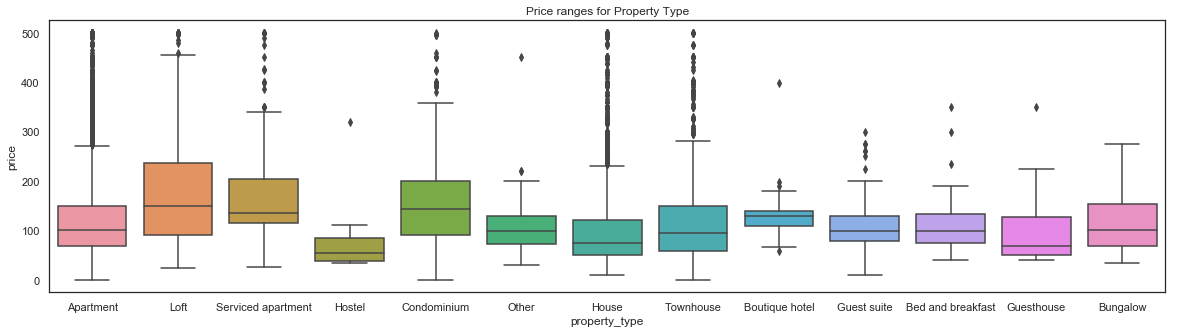

In [436]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.boxplot(y='price', x='property_type', data = airbnb.loc[airbnb['price'] <= 500.00])
sns.boxplot(y='price', x='property_type', data = airbnb).set_title("Price ranges for Property Type")
plt.rcParams['figure.figsize']=(20,10)

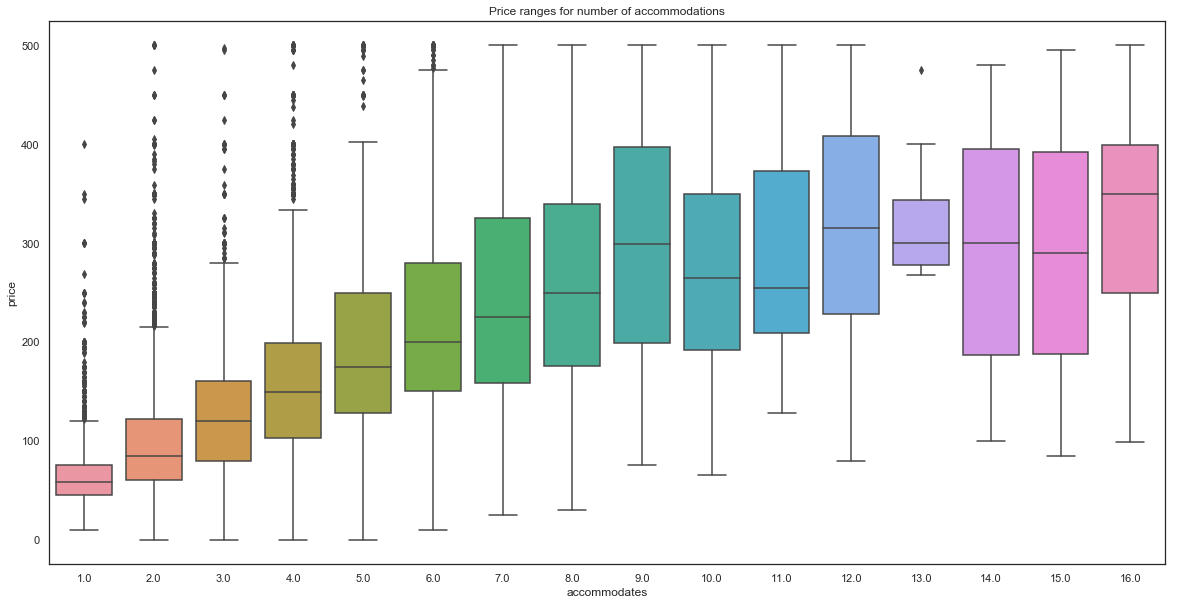

In [437]:
sns.boxplot(y='price', x='accommodates', data = airbnb).set_title("Price ranges for number of accommodations")
plt.rcParams['figure.figsize']=(10,5)

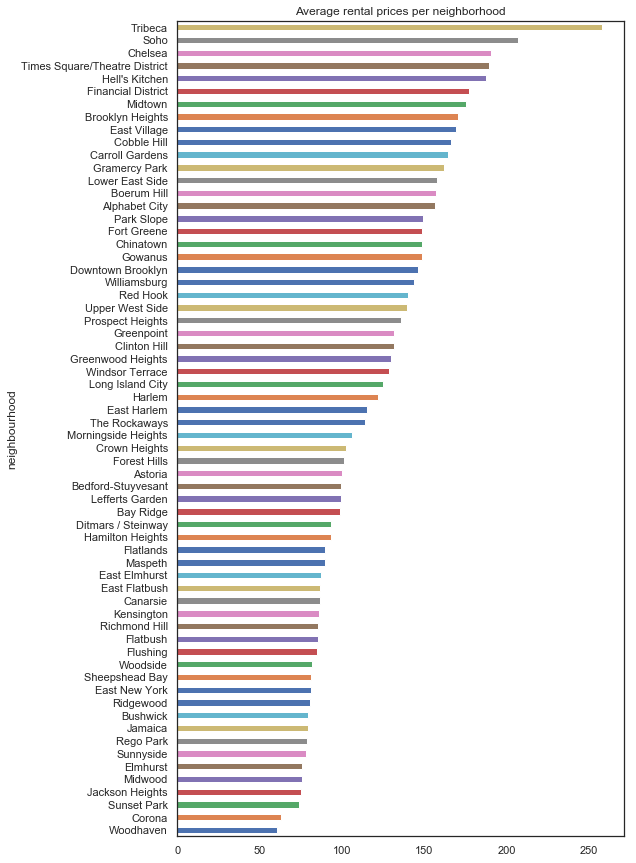

In [441]:
neighb_means = airbnb.groupby('neighbourhood')['price'].mean()
neighb_means.sort_values(ascending = True).plot(x='neighbourhood', y='price', kind='barh', 
                                                     title = "Average rental prices per neighborhood", figsize = (8, 15), sort_columns = True)


## Here are a bunch of ways to look at how all of our numerical variables correlate with each other

In [442]:
airbnb.corr()

,med_zillow_price,price,beds,bathrooms,accommodates,review_scores_rating,number_of_reviews
med_zillow_price,1.000000,0.315147,-0.013526,-0.026246,0.012060,-0.001845,-0.019419
price,0.315147,1.000000,0.491771,0.181984,0.597162,0.080291,0.003604
beds,-0.013526,0.491771,1.000000,0.270493,0.810324,-0.021895,0.094713
bathrooms,-0.026246,0.181984,0.270493,1.000000,0.240880,-0.014147,-0.018096
accommodates,0.012060,0.597162,0.810324,0.240880,1.000000,-0.012635,0.114583
review_scores_rating,-0.001845,0.080291,-0.021895,-0.014147,-0.012635,1.000000,0.015079
number_of_reviews,-0.019419,0.003604,0.094713,-0.018096,0.114583,0.015079,1.000000


In [443]:
def remove_apostrophe(dataframe):
    dataframe.columns = [x.replace("'","") for x in dataframe.columns]
    
def remove_period(dataframe):
    dataframe.columns = [x.replace(".","") for x in dataframe.columns]
    
def remove_dash(dataframe):
    dataframe.columns = [x.replace("-","") for x in dataframe.columns]
    
def remove_slash(dataframe):
    dataframe.columns = [x.replace("/","") for x in dataframe.columns]
    
def remove_spaces(dataframe):
    dataframe.columns = [x.replace(" ","") for x in dataframe.columns]
    
remove_apostrophe(airbnb)
remove_period(airbnb)
remove_dash(airbnb)
remove_slash(airbnb)
remove_spaces(airbnb)

In [444]:
abs(airbnb.corr())>0.75

,med_zillow_price,price,beds,bathrooms,accommodates,review_scores_rating,number_of_reviews
med_zillow_price,True,False,False,False,False,False,False
price,False,True,False,False,False,False,False
beds,False,False,True,False,True,False,False
bathrooms,False,False,False,True,False,False,False
accommodates,False,False,True,False,True,False,False
review_scores_rating,False,False,False,False,False,True,False
number_of_reviews,False,False,False,False,False,False,True


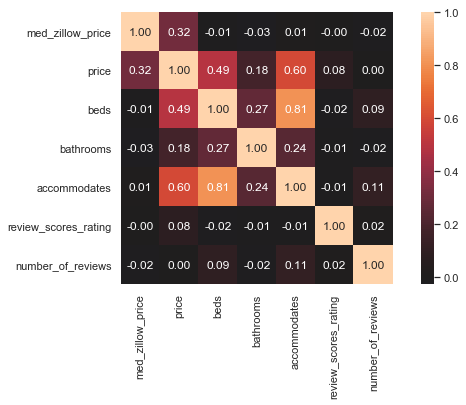

In [445]:
sns.heatmap(airbnb.corr(), center=0, cbar = True, annot=True, square = True, fmt = '.2f');

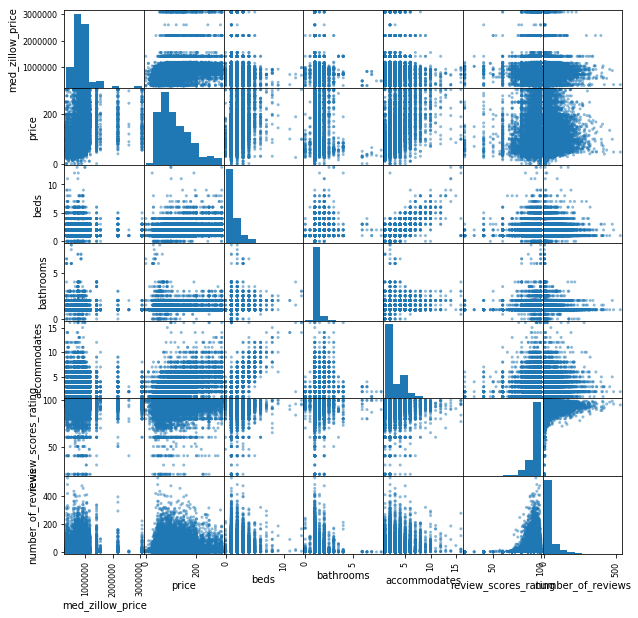

In [145]:
pd.plotting.scatter_matrix(airbnb,figsize  = [10, 10]);

### Include the Categorical Variables.

Because Regression Analysis can only use Numerical Values (because you can't chart "loft" vs "townhouse"), we include categorical variables by creating "dummy" variables. This turns category values in into either ones or zeroes.

In [446]:
#Get dummy variables for all of our categorial variables. That's neighborhoods, boroughs, and property_types
neighborhoods = pd.get_dummies(airbnb["neighbourhood"], prefix="hood", drop_first = True)
boroughs = pd.get_dummies(airbnb['borough'], prefix = "borough", drop_first = True)
property_type = pd.get_dummies(airbnb['property_type'], prefix = "type", drop_first = True)
beds = airbnb['beds']
bathrooms = airbnb['bathrooms']
# beds = pd.get_dummies(airbnb['beds'], prefix = "beds", drop_first = True)
# bathrooms = pd.get_dummies(airbnb['bathrooms'], prefix = "bathrooms", drop_first = True)
price = airbnb['price']
med_zillow_price = airbnb['med_zillow_price']
accommodates = airbnb['accommodates']
review_scores_rating = airbnb['review_scores_rating']
number_of_reviews = airbnb['number_of_reviews']
#create a dataframe with categorial dummy variables and numerical variables
data_fin = pd.concat([boroughs, neighborhoods, property_type, price, beds, bathrooms, med_zillow_price, accommodates, review_scores_rating, number_of_reviews], axis=1)

In [447]:
data_fin.head()

,borough_Manhattan,borough_Queens,borough_Staten Island,hood_Astoria,hood_Bay Ridge,hood_Bedford-Stuyvesant,hood_Boerum Hill,hood_Brooklyn Heights,hood_Bushwick,hood_Canarsie,...,type_Other,type_Serviced apartment,type_Townhouse,price,beds,bathrooms,med_zillow_price,accommodates,review_scores_rating,number_of_reviews
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,150.0,3.0,1.0,2188500,4.0,89.0,394.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,123.0,1.0,1.0,2188500,2.0,92.0,356.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,130.0,1.0,1.0,2188500,2.0,96.0,19.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,250.0,1.0,1.0,2188500,2.0,96.0,18.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,226.0,2.0,1.0,2188500,2.0,90.0,26.0


In [448]:
def remove_apostrophe(dataframe):
    dataframe.columns = [x.replace("'","") for x in dataframe.columns]
    
def remove_period(dataframe):
    if type(dataframe.columns) == str:
        dataframe.columns = [x.replace(".","") for x in dataframe.columns]
    
def remove_dash(dataframe):
    dataframe.columns = [x.replace("-","") for x in dataframe.columns]
    
def remove_slash(dataframe):
    dataframe.columns = [x.replace("/","") for x in dataframe.columns]

def remove_spaces(dataframe):
    dataframe.columns = [x.replace(" ","") for x in dataframe.columns]
    
remove_apostrophe(data_fin)
remove_period(data_fin)
remove_dash(data_fin)
remove_slash(data_fin)
remove_spaces(data_fin)

In [243]:
# from sklearn.linear_model import LinearRegression
# #Uses the Feature Ranking w/ Recursive Feature Elimination Feature Selection
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression

# #Choose n top features based on p-values
# linreg = LinearRegression()
# selector = RFE(linreg, n_features_to_select = 5)
# selector = selector.fit(predictors, data_fin["price"])

# #Responds with variables and whether they meet top n features or not
# #selector.support_ 
# #Responds with ranking of variables
# #selector.ranking_
# # estimators = selector.estimator_
# # print(estimators.coef_)
# # print(estimators.intercept_)

Let's create our base model. This includes every single feature (both numerical and categorical), including every single neighborhood, borough, number of bathrooms, etc).

In [449]:
#Include every variable as a feature
features = data_fin.drop('price', axis=1)
#Make "price" our Target, or Y
target = data_fin.price

In [450]:
data_fin.columns

Index(['borough_Manhattan', 'borough_Queens', 'borough_StatenIsland',
       'hood_Astoria', 'hood_BayRidge', 'hood_BedfordStuyvesant',
       'hood_BoerumHill', 'hood_BrooklynHeights', 'hood_Bushwick',
       'hood_Canarsie', 'hood_CarrollGardens', 'hood_Chelsea',
       'hood_Chinatown', 'hood_ClintonHill', 'hood_CobbleHill', 'hood_Corona',
       'hood_CrownHeights', 'hood_DitmarsSteinway', 'hood_DowntownBrooklyn',
       'hood_EastElmhurst', 'hood_EastFlatbush', 'hood_EastHarlem',
       'hood_EastNewYork', 'hood_EastVillage', 'hood_Elmhurst',
       'hood_FinancialDistrict', 'hood_Flatbush', 'hood_Flatlands',
       'hood_Flushing', 'hood_ForestHills', 'hood_FortGreene', 'hood_Gowanus',
       'hood_GramercyPark', 'hood_Greenpoint', 'hood_GreenwoodHeights',
       'hood_HamiltonHeights', 'hood_Harlem', 'hood_HellsKitchen',
       'hood_JacksonHeights', 'hood_Jamaica', 'hood_Kensington',
       'hood_LeffertsGarden', 'hood_LongIslandCity', 'hood_LowerEastSide',
       'hood_Maspeth

In [451]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Create training and testing set. Training is 80% of entire set
features = data_fin.drop('price', axis=1)
target = data_fin.price
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=32,test_size=0.2)

#Create Ordinary least squares Linear Regression.
lm = linear_model.LinearRegression()
#Fit that regression to our training set
model_base = lm.fit(X_train, y_train)

#Create y-value predictions based on our testing X-values set
y_pred = lm.predict(X_test)

print("Base MAE: " , metrics.mean_absolute_error(y_test, y_pred))
print("Base MSE: " , metrics.mean_squared_error(y_test, y_pred))
print("Base RMSE: " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Base MAE:  37.499307821716464
Base MSE:  2785.7342698297375
Base RMSE:  52.78005560654268


In [377]:
data_fin.head()

,borough_Manhattan,borough_Queens,hood_Astoria,hood_BayRidge,hood_BedfordStuyvesant,hood_BoerumHill,hood_BrooklynHeights,hood_Bushwick,hood_Canarsie,hood_CarrollGardens,...,type_Loft,type_Servicedapartment,type_Townhouse,price,beds,bathrooms,med_zillow_price,accommodates,review_scores_rating,number_of_reviews
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,150.0,3.0,1.0,2188500,4.0,89.0,394.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,123.0,1.0,1.0,2188500,2.0,92.0,356.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,130.0,1.0,1.0,2188500,2.0,96.0,19.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,250.0,1.0,1.0,2188500,2.0,96.0,18.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,226.0,2.0,1.0,2188500,2.0,90.0,26.0


In [403]:
from statsmodels.formula.api import ols

outcome = str('price')
predictors = data_fin.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     332.2
Date:                Fri, 07 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:00:04   Log-Likelihood:            -1.0344e+05
No. Observations:               19936   AIC:                         2.070e+05
Df Residuals:                   19874   BIC:                         2.075e+05
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -15.5122      7.773     -1.996      0.046     -30.749      -0.276
borough_Manhattan          37.8372      6.953      5.442      0.000      24.208      51.466
borough_Queens            -10.7411     21.836     -0.492      0.623     -53.541      32.059
hood_Astoria                3.0154     15.246      0.198      0.843     -26.867      32.898
hood_BayRidge             -20.4951      7.564     -2.710      0.007     -35.321      -5.670
hood_BedfordStuyvesant    -11.9430      6.773     -1.763      0.078     -25.218       1.332
hood_BoerumHill            27.8165      7.387      3.766      0.000      13.337      42.295
hood_BrooklynHeights       45.8703      7.895      5.810      0.000      30.395      61.346
hood_Bushwick             -23.4557      6.834     -3.432      0.001     -36.850     -10.061
hood_Canarsie             -26.2361      7.945     -3.302      0.001     -41.808     -10.664
hood_CarrollGardens        30.9337      7.467      4.143      0.000      16.297      45.570
hood_Chelsea                8.0536      4.340      1.855      0.064      -0.454      16.561
hood_Chinatown            -11.9896      3.639     -3.295      0.001     -19.123      -4.856
hood_ClintonHill           12.5200      6.915      1.811      0.070      -1.034      26.074
hood_CrownHeights          -5.0973      6.878     -0.741      0.459     -18.578       8.384
hood_DitmarsSteinway       -6.7315     15.645     -0.430      0.667     -37.396      23.933
hood_EastFlatbush         -23.5516      7.249     -3.249      0.001     -37.761      -9.342
hood_EastHarlem           -29.4733      2.618    -11.257      0.000     -34.605     -24.341
hood_EastNewYork          -27.1869      7.086     -3.837      0.000     -41.076     -13.298
hood_EastVillage            7.8163      2.432      3.215      0.001       3.050      12.582
hood_Elmhurst             -14.8434     15.527     -0.956      0.339     -45.278      15.592
hood_FinancialDistrict     11.8573      3.940      3.009      0.003       4.134      19.580
hood_Flatbush             -26.0832      6.911     -3.774      0.000     -39.629     -12.538
hood_Flushing             -11.7258     15.369     -0.763      0.445     -41.849      18.398
hood_ForestHills           -9.7872     15.683     -0.624      0.533     -40.527      20.953
hood_FortGreene            31.2284      7.159      4.362      0.000      17.196      45.261
hood_Gowanus               16.8085      7.634      2.202      0.028       1.845      31.772
hood_GramercyPark           2.6833      3.939      0.681      0.496      -5.038      10.405
hood_Greenpoint            13.8437      6.879      2.012      0.044       0.360      27.327
hood_GreenwoodHeights       2.3260      7.614      0.306      0.760     -12.597      17.249
hood_HamiltonHeights      -49.8502      2.631  

### But what do these mean?
* __MAE__: Mean Absolute Error. This is an average of absolute differences between the target values and the predictions. The MAE is a linear score which means that all the individual differences are weighted equally in the average. In this case, my predictions are likely to be within $37 of the actual price!


* __MSE__: Mean Squared Error. This is the average squared error of our predictions. For each point, it calculates square difference between the predictions and the target and then average those values. The higher the value, the worse (or less reliable) the model is. A zero would be a perfect model.


* __RMSE__: Root Mean Squared Error. This is just the square root of MSE!  The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. If the RMSE=MAE, then all the errors are of the same magnitude

Text(0.5, 1.0, 'Test vs. Prediction points')

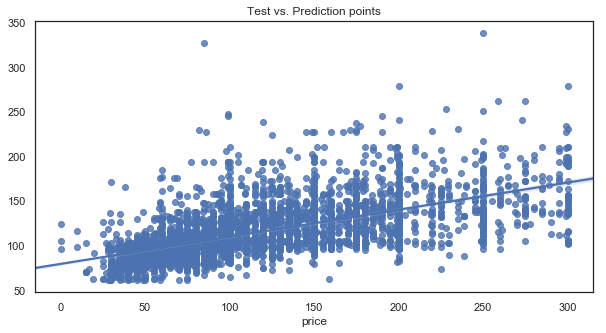

In [373]:
sns.regplot(y_test, y_pred).set_title('Test vs. Prediction points')

Now that we have a baseline model that includes all of our features, let's pick and choose specific features that are quantifiably more relevant to our predictions. This method is called "Feature Selection", and there are several approaches to this.


In [355]:
from sklearn import preprocessing
from sklearn import pipeline
#Create training and testing set. Training is 80% of entire set
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=32,test_size=0.2)
scaler = preprocessing.StandardScaler()
#Take out all categorical variables, because there's no point in scaling 1's and 0's
scaler.fit(X_train.iloc[:,-6:])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [356]:
X_train.columns[-6:]

Index(['beds', 'bathrooms', 'med_zillow_price', 'accommodates',
       'review_scores_rating', 'number_of_reviews'],
      dtype='object')

### Our first step is Feature Scaling. 

The ranges of our values in our data range from million of dollars (Zillow home prices) to number of bathrooms in a home, so we normalize the values so that each feature contributes proportiontely to the predicted value.


The method we are using to scale our features in this case is Standard Scaling, which subtracts the mean for each unit and divides by the standard deviation. If there's a value less than the mean, the scaled number will be negative.



In [357]:
#Create a new dataframe with new scaled numerical variables
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,-6:]), columns=X_train.columns[-6:], index = X_train.index)

#Add back in your categorical variables
features_scaled_train = pd.concat([X_train.iloc[:,:-6],features_scaled_train], axis=1)

features_scaled_train.head()

#if there's a value less than the mean, the scaled number will be negative. This is because the scaled number
#is z= (x-u)/s.
#x = value
#u = mean of training samples
#s = standard deviation
#Create a new dataframe with new scaled numerical variables
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,-6:]), columns=X_train.columns[-6:], index = X_test.index)
features_scaled_test = pd.concat([X_test.iloc[:,:-6],features_scaled_test], axis=1)
features_scaled_test.head()

,borough_Manhattan,borough_Queens,hood_Astoria,hood_BayRidge,hood_BedfordStuyvesant,hood_BoerumHill,hood_BrooklynHeights,hood_Bushwick,hood_Canarsie,hood_CarrollGardens,...,type_House,type_Loft,type_Servicedapartment,type_Townhouse,beds,bathrooms,med_zillow_price,accommodates,review_scores_rating,number_of_reviews
11238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.557466,-0.292637,-0.161162,0.154990,-0.611196,0.305271
11105,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.539716,-0.292637,-0.573521,-0.474442,0.749406,-0.224060
10009,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.557466,-0.292637,0.639708,-0.474442,0.130951,-0.554892
11412,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.557466,-0.292637,-1.418464,-0.474442,0.749406,-0.444615
10003,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.557466,-0.292637,1.723131,-1.103873,-2.590252,-0.576948


## The next step in data preprocessing is assigning Polynomials and interaction variables.

* Polynomials are used if the variables have a polynomial relationship with price (2 if the data looks like a parabola, 3 if it has a cubic shape, etc).

* Interaction variables create a new feature that describes how each feature relates to each other feature 

In [358]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_many_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
#features_many_train.head()
features_many_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))
#features_many_test.head()

#preprocessing.PolynomialFeatures = Generate polynomial and interaction features.
#Generate a new feature matrix consisting of all polynomial combinations of the features with 
#degree less than or equal to the specified degree. For example, if an input sample is two dimensional 
#and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
#poly.fit_transform = Fit to data, then transform it.

### Next, let's take out low-variance features.

We do this because low-variance features won't tell us much regarding price outcome. Think about it .. if all the AirBnB cleaning fees we $50, and some were $51, cleaning fees wouldn't impact total price very much.


In [359]:
from sklearn.feature_selection import VarianceThreshold

#Feature selector that removes all low-variance features.
#This feature selection algorithm looks only at the features (X), not the desired outputs (y), 
#and can thus be used for unsupervised learning.

thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

features_selected_train = variance_threshold_selector(features_many_train)

### Let's check out how all of these interaction variables correlate with each other

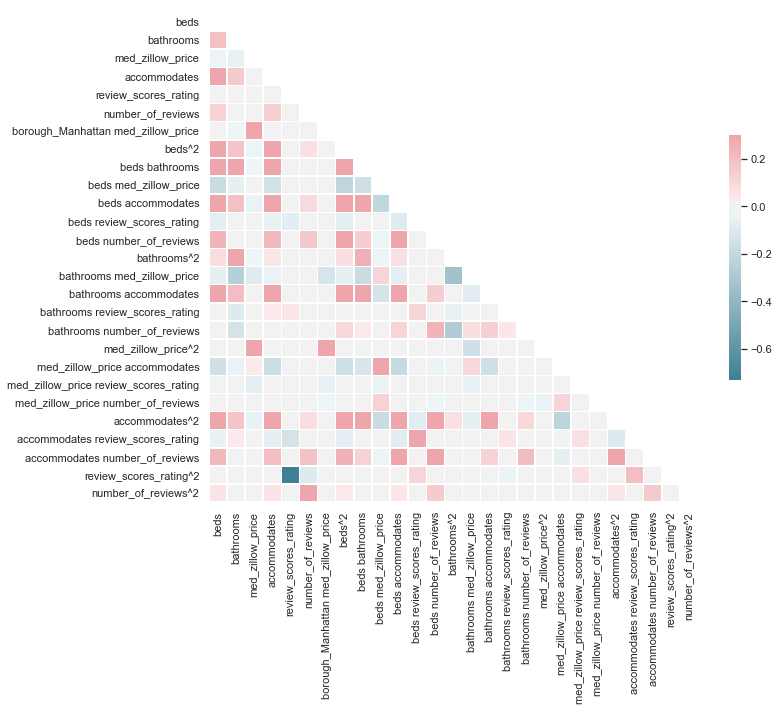

In [360]:
import seaborn as sns

sns.set(style="white")
# Compute the correlation matrix between selected features that have high variance
corr = features_selected_train.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Now, let's take out any interaction variables that have too high of a correlation.

We do this because there's little point in keeping variables that are essentially the same as other variables!

In [361]:
# Create correlation matrix, take absolute values of each correlation
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [305]:
to_drop

[]

In [345]:
features_selected_train.drop(columns=to_drop, inplace=True)

# Finally, let's implement a feature selection class. 
We'll use one called "SelectKBest", which selects K number of features best on a given scoring system. The scoring system we chose was 'f_regression'. 

f_regression is a linear model for testing the individual effect of each of many regressors.

In [362]:
#SelectKBest = Select features according to the k highest scores.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif

In [363]:
def information_selector(X, y, scoring, k=12):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [364]:
#score each feature by mutual_info_regression
test = SelectKBest(score_func=mutual_info_regression, k=5)
fit = test.fit(features_selected_train, y_train)

In [365]:
features_selected_train[features_selected_train.columns[fit.get_support(indices=True)]].head()

,beds med_zillow_price,beds accommodates,bathrooms accommodates,med_zillow_price accommodates,accommodates^2
0,-0.152992,0.264485,0.138839,-0.130206,0.225095
1,-0.356615,-0.437288,-0.229551,0.501801,0.615317
2,-0.356615,0.264485,0.138839,-0.303504,0.225095
3,-0.152992,0.264485,0.138839,-0.130206,0.225095
4,-0.327334,0.264485,0.138839,-0.278584,0.225095


In [367]:
features_selected_train = information_selector(features_selected_train, y_train, f_regression, k=12)

In [368]:
features_selected_train.head()

,beds,med_zillow_price,accommodates,review_scores_rating,borough_Manhattan med_zillow_price,beds^2,beds bathrooms,beds accommodates,beds number_of_reviews,bathrooms accommodates,med_zillow_price^2,accommodates^2
0,-0.557466,0.274441,-0.474442,0.502024,0.274441,0.310768,0.163135,0.264485,-0.440671,0.138839,0.075318,0.225095
1,-0.557466,0.639708,0.784421,-0.487505,0.639708,0.310768,0.163135,-0.437288,0.333924,-0.229551,0.409227,0.615317
2,-0.557466,0.639708,-0.474442,-0.363814,0.639708,0.310768,0.163135,0.264485,-1.190676,0.138839,0.409227,0.225095
3,-0.557466,0.274441,-0.474442,-0.240123,0.274441,0.310768,0.163135,0.264485,0.026545,0.138839,0.075318,0.225095
4,-0.557466,0.587182,-0.474442,0.749406,0.587182,0.310768,0.163135,0.264485,0.297038,0.138839,0.344783,0.225095


In [369]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train, y_train)


After fitting the model to these specific features, we get an RMSE of 46.

In [370]:
features_selected_test = features_many_test[features_selected_train.columns]
y_pred = lm.predict(features_selected_test)

print("K Best Feature Selection MAE: " ,metrics.mean_absolute_error(y_test, y_pred))
print("K Best Feature Selection MSE: " , metrics.mean_squared_error(y_test, y_pred))
print("K Best Feature Selection RMSE: " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


K Best Feature Selection MAE:  35.086257768465
K Best Feature Selection MSE:  2135.3049034451697
K Best Feature Selection RMSE:  46.20935947884551


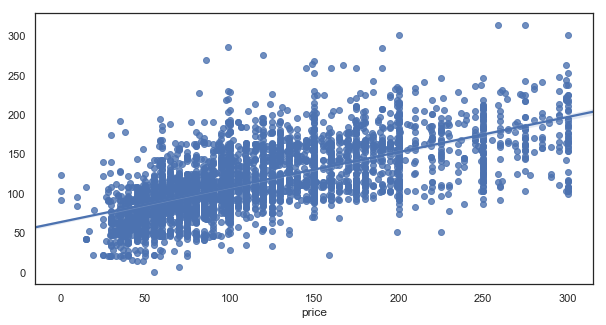

In [352]:
sns.regplot(y_test, y_pred)

### Using Lasso Regression for Feature Engineering

This type of analysis selects variables that minimizes prediction error for our price. It puts constraints on model parameters that causes regression coefficients to shrink towards zero. Variables with non-zero regression coefficients are most strongly associated with price.


In [371]:
## training the model
from sklearn.linear_model import Lasso

lassoReg = Lasso(alpha=0.05, normalize=True)
lassoReg.fit(X_train,y_train)
y_pred = lassoReg.predict(X_test)

#calculating mse

print('Lasso MSE:', metrics.mean_squared_error(y_test, y_pred))
print('Lasso RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#this many Standard Deviations away from the mean..?
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ y_test.std())


coef = pd.DataFrame(data=lassoReg.coef_, index=X_train.columns )
model_coef = coef.sort_values(by=0).T

#model_coef.plot(kind='bar', title='Lasso Model Coefficients', legend=False, figsize=(16,8))


Lasso MSE: 2464.302617216653
Lasso RMSE: 49.64174268915882
0.7950846996579852


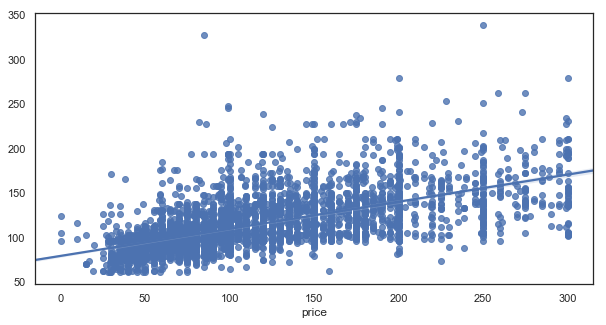

In [372]:
sns.regplot(y_test, y_pred)

# Take a walk through the Random Forest

Using Random Forest Regressor fits a bunch of classifying decision trees on various sub-samples of the dataset. Think about this forest as being a bunch of trees (which they typically are). Each tree is a decision tree, where it's going through each variable as the nodes of each tree to make a prediction. You might go through the thought process of, "Is the apartment in Chinatown or Gowanus? Is it a private room or the entire apartment? Does it have two bathrooms or five?" and be able to estimate a price. A forest is like a collection of "trees" just like those - because it's better to have the average of a million samples than just one person's experience.


In [354]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


y = data_fin.price
x = data_fin.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=600, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('Random Forest RMSE: %.3f' % rmse_rf)
print('Random Forest R^2: %.3f' % (r2_score(y_test, y_test_pred)))

Random Forest RMSE: 44.610
Random Forest R^2: 0.480


# Most important features in Random Forest predictors

In [321]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,est_int,coefs
59,accommodates,0.353687
58,med_zillow_price,0.204835
61,number_of_reviews,0.150472
60,review_scores_rating,0.088690
56,beds,0.031367
57,bathrooms,0.030489
53,type_Loft,0.008882
50,type_Condominium,0.008446
52,type_House,0.007341
0,borough_Manhattan,0.007290


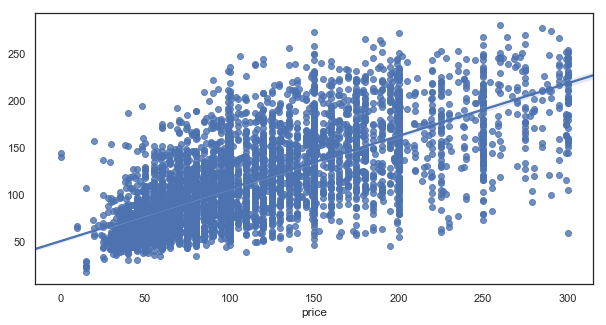

In [228]:
#Random Forest 
sns.regplot(y_test, y_test_pred)

# Model Comparisons:
* __Base RMSE__ (all features): 44.8
* __Variance Threshold, Correlation Filter and K Best Feature Scaling RMSE__: 46.2
* __Lasso RMSE__: 49.6
* __Random Forest RMSE:__ 44.6